# Download libraries and set up API KEY

In [44]:
%pip install llama-index-readers-file

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.4/290.4 kB 7.4 MB/s eta 0:00:00


In [1]:
%pip install llama-index-multi-modal-llms-openai
%pip install llama-index-multi-modal-llms-replicate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.4/15.4 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.1/136.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.0/311.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.4/49.4 kB 1.5 MB/s eta 0:00:00


In [2]:
import os

OPENAI_API_TOKEN = ""
os.environ["OPENAI_API_KEY"] = OPENAI_API_TOKEN

## Initialize Pydantic Class for Receipt

In [4]:
from pydantic import BaseModel, Field
from typing import List, Union
from datetime import date, time
from enum import Enum

class ItemInfo(BaseModel):
    name: str = Field(..., description="Name of the item")
    unit: float = Field(..., description="Quantity of the item")
    price: float = Field(..., description="Price per unit of the item")
    amount: float = Field(..., description="Total amount for the item")

class PaymentMethodEnum(str, Enum):
    tarjeta = 'tarjeta'
    efectivo = 'efectivo'

class ReceiptInfo(BaseModel):
    store: str = Field(..., description="Store name")
    address: str = Field(..., description="Address of the store")
    city: str = Field(..., description="City where the store is located")
    phone: str = Field(..., description="Phone number of the store")
    receipt_no: str = Field(..., description="Receipt number")
    date: str = Field(..., description="Date of the receipt in DD/MM/YYYY format")
    time: str = Field(..., description="Time of the transaction")
    items: List[ItemInfo] = Field(..., description="List of items purchased")
    total: float = Field(..., description="Total amount of the receipt")
    number_items: int = Field(..., description="Number of items in the receipt")
    payment_method: PaymentMethodEnum = Field(..., description="Payment method used")

In [53]:
class Item(BaseModel):
    name: str
    unit: float
    price: float
    amount: float

class PaymentMethodEnum(str, Enum):
    tarjeta = 'tarjeta'
    efectivo = 'efectivo'

class Receipt(BaseModel):
    store: str
    address: str
    city: str
    phone: str
    receipt_no: str
    date: str
    time: str
    items: List[Item]
    total: float
    number_items: int
    payment_method: PaymentMethodEnum

## Load OpenAI GPT4V Multi-Modal LLM Model

In [70]:
from llama_index.multi_modal_llms.openai import OpenAIMultiModal
from llama_index.core import SimpleDirectoryReader

# put your local directory here
image_documents = SimpleDirectoryReader("/content/pics").load_data()

openai_mm_llm = OpenAIMultiModal(
    model="gpt-4-vision-preview", api_key=OPENAI_API_TOKEN, max_new_tokens=1000
)

In [59]:
image_documents

[ImageDocument(id_='ef7c6415-5950-4f7e-9234-bc9523913296', embedding=None, metadata={'file_path': '/content/pics/IMG_7318.jpg', 'file_name': 'IMG_7318.jpg', 'file_type': 'image/jpeg', 'file_size': 1353153, 'creation_date': '2024-04-18', 'last_modified_date': '2024-04-18'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={}, text='', start_char_idx=None, end_char_idx=None, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path='/content/pics/IMG_7318.jpg', image_url=None, image_mimetype=None, text_embedding=None)]

## Plot the image

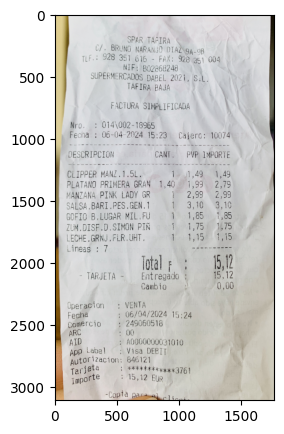

In [64]:
from PIL import Image
import matplotlib.pyplot as plt


image1 = Image.open('/content/pics/IMG_7318.jpg').convert("RGB")

plt.figure(figsize=(16, 5))
plt.imshow(image1)


## Using Multi-Modal Pydantic Program to generate structured data from GPT4V Output for Restaurant Image

In [67]:
from llama_index.core.program import MultiModalLLMCompletionProgram
from llama_index.core.output_parsers import PydanticOutputParser

prompt_template_str = """\
    Extract data from the image and return a response \
    with the following JSON format. In you don't know the value, don't make it up. \
"""
openai_program = MultiModalLLMCompletionProgram.from_defaults(
    output_parser=PydanticOutputParser(ReceiptInfo),
    image_documents=image_documents,
    prompt_template_str=prompt_template_str,
    multi_modal_llm=openai_mm_llm,
    verbose=True,
)

In [68]:
response = openai_program()


> Raw output: ```json
{
  "store": "SPAR TAÜRA",
  "address": "C/ BRUÑO NARANJO DIAZ, 35-QB",
  "city": "TAÜRA",
  "phone": "928 94 29 81",
  "receipt_no": "FACTURA SIMPLIFICADA: 00074",
  "date": "06/04/2021",
  "time": "15:23",
  "items": [
    {
      "name": "PLATANO PRIMERA GRAN",
      "unit": 1.41,
      "price": 1.39,
      "amount": 1.96
    },
    {
      "name": "GOFRIO B.K. LIDY MEL",
      "unit": 1,
      "price": 1.85,
      "amount": 1.85
    },
    {
      "name": "MANZANA ROJA DELICIOUS",
      "unit": 0.62,
      "price": 2.99,
      "amount": 1.85
    },
    {
      "name": "PIMIENTO ITALIANO VERDE",
      "unit": 0.47,
      "price": 2.75,
      "amount": 1.29
    },
    {
      "name": "LECHE DESNATADA ML",
      "unit": 1,
      "price": 0.75,
      "amount": 0.75
    }
  ],
  "total": 12.15,
  "number_items": 5,
  "payment_method": "tarjeta"
}
```


In [69]:
for res in response:
    print(res)

('store', 'SPAR TAÜRA')
('address', 'C/ BRUÑO NARANJO DIAZ, 35-QB')
('city', 'TAÜRA')
('phone', '928 94 29 81')
('receipt_no', 'FACTURA SIMPLIFICADA: 00074')
('date', '06/04/2021')
('time', '15:23')
('items', [ItemInfo(name='PLATANO PRIMERA GRAN', unit=1.41, price=1.39, amount=1.96), ItemInfo(name='GOFRIO B.K. LIDY MEL', unit=1.0, price=1.85, amount=1.85), ItemInfo(name='MANZANA ROJA DELICIOUS', unit=0.62, price=2.99, amount=1.85), ItemInfo(name='PIMIENTO ITALIANO VERDE', unit=0.47, price=2.75, amount=1.29), ItemInfo(name='LECHE DESNATADA ML', unit=1.0, price=0.75, amount=0.75)])
('total', 12.15)
('number_items', 5)
('payment_method', <PaymentMethodEnum.tarjeta: 'tarjeta'>)


`Observation`:
* Model can output fields partially, though majority of the fileds is mixed up, some information is made up.